In [1]:
def zigzag(df, threshold=0.10, column='close', pct=True):
    """
    Calculate Zig-Zag points (swing highs/lows) on OHLC data.

    Args:
        df (pd.DataFrame): DataFrame with columns ['open', 'high', 'low', 'close']. Index should be datetime or string.
        threshold (float): The minimum change to recognize a new high/low. If pct=True, this is treated as percentage (e.g., 0.05 means 5%).
        column (str): The price column to use for calculation. Usually 'close', but can be 'high', 'low', etc.
        pct (bool): If True, threshold is treated as percentage; else, as absolute price difference.

    Returns:
        pd.DataFrame: Original df with two new columns: 'zigzag' (values at swing points, else NaN), and 'zigzag_type' (1 for high, -1 for low, NaN otherwise).
    """
    df = df.copy()
    prices = df[column].values
    indices = df.index

    # Initialize results
    zigzag = [None] * len(df)
    zigzag_type = [None] * len(df)

    # Initial state: find high after low
    last_pivot_idx = 0
    last_pivot_price = prices[0]
    searching_for = 'high'  # alternate between 'high'/'low'

    # Mark first point as a pivot (could be high or low, doesn't matter yet)
    zigzag[0] = prices[0]
    zigzag_type[0] = -1  # Assume starting from a low
    temp_pivot_idx = 0
    temp_pivot_price = prices[0]

    for i in range(1, len(prices)):
        price = prices[i]

        if searching_for == 'high':
            lastSearch = 'high'
            # Update temp_pivot if new high found
            if price > temp_pivot_price:
                temp_pivot_price = price
                temp_pivot_idx = i

            # Calculate drop from temp_pivot_price
            drop = (temp_pivot_price - price) / temp_pivot_price if pct else (temp_pivot_price - price)
            if drop >= threshold:
                # Confirm high
                zigzag[temp_pivot_idx] = temp_pivot_price
                zigzag_type[temp_pivot_idx] = 1
                last_pivot_idx = temp_pivot_idx
                last_pivot_price = temp_pivot_price
                # Switch to searching for low
                searching_for = 'low'
                temp_pivot_idx = i
                temp_pivot_price = price
                lastSearch = 'high'

        elif searching_for == 'low':
            lastSearch = 'low'
            # Update temp_pivot if new low found
            if price < temp_pivot_price:
                temp_pivot_price = price
                temp_pivot_idx = i

            # 價格自低位回升的幅度
            rise = (price - temp_pivot_price) / temp_pivot_price if pct else (price - temp_pivot_price)
            if rise >= threshold:
                # Confirm low
                zigzag[temp_pivot_idx] = temp_pivot_price
                zigzag_type[temp_pivot_idx] = -1
                last_pivot_idx = temp_pivot_idx
                last_pivot_price = temp_pivot_price
                # Switch to searching for high
                searching_for = 'high'
                temp_pivot_idx = i
                temp_pivot_price = price
                lastSearch = 'low'

        # recorde the searchingFor and the drop
        df.loc[indices[i], 'prev_searching_for'] = lastSearch
        df.loc[indices[i], 'searching_for'] = searching_for

        try:
            # print(drop if searching_for == 'high' else rise)
            df.loc[indices[i], '反彈或回落'] = drop if lastSearch == 'high' else rise
        except Exception as e:
            continue
    
    # Optionally, mark the last temp_pivot as a point (it might not be a confirmed swing yet)
    zigzag[temp_pivot_idx] = temp_pivot_price
    zigzag_type[temp_pivot_idx] = 1 if searching_for == 'high' else -1

    df['zigzag'] = zigzag
    df['zigzag_type'] = zigzag_type
    return df


def findPivotSignal(zz, testCcy, holdDay):
    import numpy as np
    import pandas as pd

    confirmed_high = []
    confirmed_high_date = []
    confirmed_low = []
    confirmed_low_date = []

    last_confirmed_high = np.nan
    last_confirmed_high_date = pd.NaT
    last_confirmed_low = np.nan
    last_confirmed_low_date = pd.NaT

    for i, row in enumerate(zz.itertuples()):
        # --- 找上一段 searching_for == 'low' 的區間 ---
        if getattr(row, 'searching_for') == 'high' and getattr(row, 'prev_searching_for') == 'low':
            start_idx = None
            # 反向找最近一次不是low的地方
            for j in range(i-1, -1, -1):
                if zz.iloc[j]['searching_for'] != 'low':
                    start_idx = j + 1
                    break
            if start_idx is None:
                start_idx = 0
            period = zz.iloc[start_idx:i]
            if not period.empty:
                min_row = period[testCcy].idxmin()
                last_confirmed_low = zz.loc[min_row, testCcy]
                last_confirmed_low_date = row.Index

        # --- 找上一段 searching_for == 'high' 的區間 ---
        if getattr(row, 'searching_for') == 'low' and getattr(row, 'prev_searching_for') == 'high':
            start_idx = None
            for j in range(i-1, -1, -1):
                if zz.iloc[j]['searching_for'] != 'high':
                    start_idx = j + 1
                    break
            if start_idx is None:
                start_idx = 0
            period = zz.iloc[start_idx:i]
            if not period.empty:
                max_row = period[testCcy].idxmax()
                last_confirmed_high = zz.loc[max_row, testCcy]
                last_confirmed_high_date = row.Index

        confirmed_high.append(last_confirmed_high)
        confirmed_high_date.append(last_confirmed_high_date)
        confirmed_low.append(last_confirmed_low)
        confirmed_low_date.append(last_confirmed_low_date)

    zz['confirmed_high'] = confirmed_high
    zz['confirmed_high_date'] = confirmed_high_date
    zz['confirmed_low'] = confirmed_low
    zz['confirmed_low_date'] = confirmed_low_date


    import pandas as pd
    import numpy as np
    from pandas.tseries.offsets import BDay

    # --- Step 1: Suppress signal if confirmed_high <= confirmed_low ---
    price_col = testCcy
    zz['signal'] = 0

    for i, row in zz.iterrows():
        if pd.notnull(row['confirmed_high']) and pd.notnull(row['confirmed_low']) and row['confirmed_high'] <= row['confirmed_low']:
            zz.at[row.name, 'signal'] = 0
        elif pd.notnull(row['confirmed_high']) and row[price_col] >= row['confirmed_high'] and row['confirmed_high_date'] < row.name:
            zz.at[row.name, 'signal'] = 1
        elif pd.notnull(row['confirmed_low']) and row[price_col] <= row['confirmed_low'] and row['confirmed_low_date'] < row.name:
            zz.at[row.name, 'signal'] = -1
        # else remains 0

    # --- Step 2: Simulate position holding, NO mandatory waiting period after closing ---
    zz['position'] = 0
    current_pos = 0
    entry_date = None
    last_signal_type = 0

    for i, row in enumerate(zz.itertuples()):
        idx = row.Index
        signal = row.signal
        current_date = idx  # assumes index is datetime

        if current_pos == 0:
            if signal != 0:
                current_pos = signal
                entry_date = current_date
                zz.at[idx, 'position'] = current_pos
                last_signal_type = signal
            else:
                zz.at[idx, 'position'] = 0
        else:
            zz.at[idx, 'position'] = current_pos
            if signal == -current_pos and signal != 0:
                current_pos = 0
                entry_date = None
                zz.at[idx, 'position'] = 0
                last_signal_type = signal
            elif entry_date is not None and current_date >= (entry_date + BDay(holdDay)):
                current_pos = 0
                entry_date = None
                zz.at[idx, 'position'] = 0

    # signal_df = zz[[price_col, 'searching_for', '反彈或回落', 'confirmed_high', 'confirmed_high_date', 'confirmed_low', 'confirmed_low_date', 'signal', 'position']].copy()

    return zz


In [2]:
# import sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from datetime import datetime, timedelta

# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# startDate = '2012-01-01'
# # endDate = '2023-12-31'
# # endDate = '2025-05-22'
# endDate = '2022-12-31'

# info = myTrade.init(startDate, endDate)
# testCcy = 'NZD'
# holdDay = 3
# tmpL = [testCcy]
# info.setBasket(tmpL)

# spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
# ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
# for ccy in ohlc:
#     ohlc[ccy] = ohlc[ccy].shift(1)
#     ohlc[ccy] = ohlc[ccy].dropna()
# test = spot[testCcy]
# zz = zigzag(spot, threshold=3*0.01, column=testCcy, pct=True)
# zz = findPivotSignal(zz, testCcy, holdDay)


# # Assume zz is your DataFrame and 'AUD' is your price column

# # Calculate daily returns (log returns for numerical stability)
# zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))

# # Shift position to represent "enter at today's close, earn return tomorrow"
# zz['position_shifted'] = zz['position'].shift(1).fillna(0)

# # Strategy daily returns
# zz['strategy_log_ret'] = zz['position_shifted'] * zz['log_ret']

# # Cumulative log return, starting from capital=1
# zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()
# zz['equity_curve'] = np.exp(zz['cum_log_ret'])
# zz['daily_equity_curve'] = zz['strategy_log_ret']

# # Calculate profit
# # Final capital - initial capital
# final_capital = zz['equity_curve'].iloc[-1]
# profit = final_capital - 1

# # print(f"Final capital: {final_capital:.4f}")
# # print(f"Total profit: {profit:.4f}")

# # If you want a DataFrame showing only the equity curve:
# equity_df = zz[['equity_curve', 'daily_equity_curve', 'position', testCcy]]
# btRes = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, endDate)
# btRet_sharpe = btRes.loc['回測期間', 'yearlySharpe'] 
# btRet_sharpe


In [3]:
# import numpy as np
# import pandas as pd
# from datetime import datetime, timedelta

# # --- Only import modules once at the top ---
# import sys
# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# def optimize_fx_sharpe(
#     holdDays, testCcys, startDate='2012-01-01', endDate='2022-12-31', threshold=1.5*0.01
# ):
#     results = []
#     for testCcy in testCcys:
#         info = myTrade.init(startDate, endDate)
#         info.setBasket([testCcy])
#         spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#         ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#         for ccy in ohlc:
#             ohlc[ccy] = ohlc[ccy].shift(1).dropna()
#         for holdDay in holdDays:
#             print(f"Testing ccy = {testCcy}, holdDay = {holdDay}")
#             try:
#                 zz = zigzag(spot, threshold=threshold, column=testCcy, pct=True)
#                 zz = findPivotSignal(zz, testCcy, holdDay)
#                 zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
#                 zz['position_shifted'] = zz['position'].shift(1).fillna(0)
#                 zz['strategy_log_ret'] = zz['position_shifted'] * zz['log_ret']
#                 zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()
#                 zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#                 equity_df = zz[['equity_curve', 'strategy_log_ret', 'position', testCcy]].rename(
#                     columns={'strategy_log_ret': 'daily_equity_curve'}
#                 )
#                 btRes = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, endDate)
#                 sharpe = btRes.loc['回測期間', 'yearlySharpe']
#                 ret = btRes.loc['回測期間', 'return(%)']
#             except Exception as e:
#                 print(f"Error for {testCcy}-{holdDay}: {e}")
#                 sharpe, ret = np.nan, np.nan
#             results.append({'ccy': testCcy, 'holdDay': holdDay, 'sharpe': sharpe, 'ret': ret})
#     # Combine into a single DataFrame for easy analysis
#     results_df = pd.DataFrame(results)
#     return results_df

# # Example usage
# holdDays = [1, 2, 3, 4, 5, 10, 11, 12, 13, 14]
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'CHF', 'ZAR', 'SEK']
# results_df = optimize_fx_sharpe(holdDays, testCcys)
# print(results_df)
# # To get best by Sharpe:
# best_result = results_df.loc[results_df['sharpe'].idxmax()]
# print("Best Sharpe:", best_result)

# ## visaulize the results please 
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Suppose your results_df is already loaded as shown in your example
# # If not, you can create it with pd.read_csv or from_dict

# # Ensure 'holdDay' is numeric for plotting
# results_df['holdDay'] = pd.to_numeric(results_df['holdDay'])

# # Set up the plotting style
# sns.set(style="whitegrid")

# # 1. Sharpe Ratio vs Hold Day for each currency
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='holdDay', y='sharpe', hue='ccy', marker='o')
# plt.title('Sharpe Ratio by Hold Day for each Currency')
# plt.xlabel('Hold Days')
# plt.ylabel('Sharpe Ratio')
# plt.legend(title='Currency')
# plt.tight_layout()
# plt.show()

# # 2. Return vs Hold Day for each currency
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='holdDay', y='ret', hue='ccy', marker='o')
# plt.title('Return (%) by Hold Day for each Currency')
# plt.xlabel('Hold Days')
# plt.ylabel('Return (%)')
# plt.legend(title='Currency')
# plt.tight_layout()
# plt.show()

# # 3. If you want subplots for each currency:
# g = sns.FacetGrid(results_df, col='ccy', col_wrap=3, height=4, sharey=False)
# g.map_dataframe(sns.lineplot, x='holdDay', y='sharpe', marker='o')
# g.set_axis_labels('Hold Days', 'Sharpe Ratio')
# g.set_titles('Sharpe for {col_name}')
# plt.tight_layout()
# plt.show()



# #  Example usage:
# startDate = '2023-01-01'
# endDate = '2025-05-22'
# # testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'CAD', 'CHF', 'ZAR', 'SEK']
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'ZAR']

# equity_df, zz_dict = get_composite_equity_curve(startDate, endDate, testCcys, threshold=1*0.01)
# equity_df['mean_equity'].plot(title='Composite Strategy Equity Curve (Equally Weighted)')
# plt.xlabel('Date')
# plt.ylabel('Equity')
# plt.show()

In [4]:
# import sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# def get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.01):
#     equity_curves = []
#     zz_dict = {}

#     for testCcy in testCcys:
#         # info = myTrade.init(startDate, endDate)
#         # info.setBasket([testCcy])

#         # just for 9/6
#         info = myTrade.init(startDate, endDate, [testCcy])
        
#         spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#         ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#         for ccy in ohlc:
#             ohlc[ccy] = ohlc[ccy].shift(1).dropna()

#         # Always run zigzag first!
#         zz_base = zigzag(spot, threshold=threshold, column=testCcy, pct=True)

#         # Reverse leg: holdDay=1, reverse signal
#         zz_rev = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
#         rev_signal = -1 * zz_rev['position'].fillna(0)

#         # Direction leg: holdDay=2, same signal
#         zz_dir = findPivotSignal(zz_base.copy(), testCcy, holdDay=2)
#         dir_signal = zz_dir['position'].fillna(0)

#         # Use the same index for all signals and returns
#         zz = zz_base.copy()
#         zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
#         zz['rev_signal'] = rev_signal
#         zz['dir_signal'] = dir_signal

#         zz['composite_position'] = 0.5 * zz['rev_signal'] + 0.5 * zz['dir_signal']

#         # Strategy returns (shift to enter at today's close, earn tomorrow's return)
#         zz['strategy_log_ret'] = zz['composite_position'].shift(1).fillna(0) * zz['log_ret']
#         zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()

#         zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#         zz['daily_equity_curve'] = zz['strategy_log_ret']

#         equity_curves.append(zz['equity_curve'].rename(testCcy))
#         zz_dict[testCcy] = zz.copy()

#     # Equally weight all currencies
#     equity_df = pd.concat(equity_curves, axis=1).dropna()
#     equity_df['mean_equity'] = equity_df.mean(axis=1)
#     # add daily returns for mean_equity
#     equity_df['daily_equity_curve'] = equity_df['mean_equity'].pct_change().fillna(0)

#     return equity_df, zz_dict

# # Example usage:
# startDate = '2012-01-01'
# # endDate = '2022-12-31'
# endDate = '2025-04-30'
# testCcys = ['EUR', 'GBP', 'JPY', 'AUD', 'NZD', 'ZAR', 'SEK']
# # testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD']

# equity_df, zz_dict = get_composite_equity_curve(startDate, endDate, testCcys, threshold=1*0.01)
# equity_df['mean_equity'].plot(title='Composite Strategy Equity Curve (Equally Weighted)')
# plt.xlabel('Date')
# plt.ylabel('Equity')
# plt.show()




# #import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'Noto Sans CJK SC']  # add fonts in order of preference
# plt.rcParams['axes.unicode_minus'] = False  # fix for minus sign


In [5]:
# test = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, endDate)

In [6]:
# test = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, '2022-12-31')


In [7]:
# test.loc['回測期間', 'yearlySharpe']

In [8]:
def get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.01):
    equity_curves = []
    zz_dict = {}

    for testCcy in testCcys:
        # info = myTrade.init(startDate, endDate)
        # info.setBasket([testCcy])

        # just for 9/6
        info = myTrade.init(startDate, endDate, [testCcy])
        
        spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
        ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
        for ccy in ohlc:
            ohlc[ccy] = ohlc[ccy].shift(1).dropna()

        # Always run zigzag first!
        zz_base = zigzag(spot, threshold=threshold, column=testCcy, pct=True)

        # Reverse leg: holdDay=1, reverse signal
        zz_rev = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
        rev_signal = -1 * zz_rev['position'].fillna(0)

        # Direction leg: holdDay=2, same signal
        zz_dir = findPivotSignal(zz_base.copy(), testCcy, holdDay=2)
        dir_signal = zz_dir['position'].fillna(0)

        zz_dir_day2 = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
        dir_signal_day2 = zz_dir_day2['position'].shift(1).fillna(0)



        # Use the same index for all signals and returns
        zz = zz_base.copy()
        zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
        zz['rev_signal'] = rev_signal
        zz['dir_signal'] = dir_signal

        zz['dir_signal'] = dir_signal_day2
        zz['composite_position'] = 1 * zz['dir_signal']
        
        # Strategy returns (shift to enter at today's close, earn tomorrow's return)
        zz['strategy_log_ret'] = zz['composite_position'].shift(1).fillna(0) * zz['log_ret']
        zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()

        zz['equity_curve'] = np.exp(zz['cum_log_ret'])
        zz['daily_equity_curve'] = zz['strategy_log_ret']

        equity_curves.append(zz['equity_curve'].rename(testCcy))
        zz_dict[testCcy] = zz.copy()

    # Equally weight all currencies
    equity_df = pd.concat(equity_curves, axis=1).dropna()
    equity_df['mean_equity'] = equity_df.mean(axis=1)
    # add daily returns for mean_equity
    equity_df['daily_equity_curve'] = equity_df['mean_equity'].pct_change().fillna(0)

    return equity_df, zz_dict


=== Walk-forward window 1 ===
Train: 2012-01-01 ~ 2012-12-31
Test:  2013-01-01 ~ 2013-06-30
  [1/3] Testing threshold=0.0050... Sharpe=-0.337 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-0.260 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-0.121 <-- new best
Best threshold for window 1: 0.0150 (Sharpe=-0.121)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (128, 8)


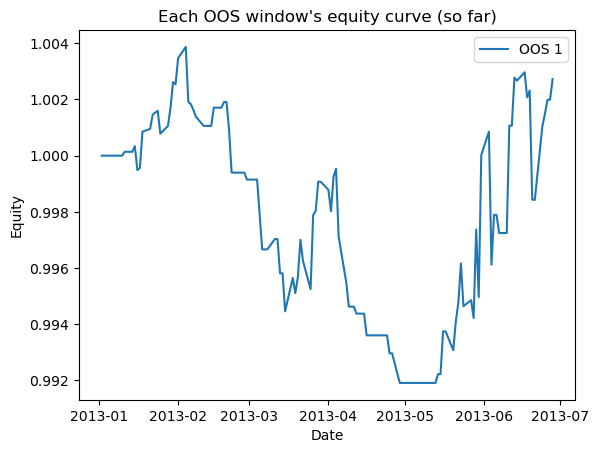


=== Walk-forward window 2 ===
Train: 2012-07-01 ~ 2013-06-30
Test:  2013-07-01 ~ 2013-12-31
  [1/3] Testing threshold=0.0050... Sharpe=-1.387 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-0.531 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-1.083
Best threshold for window 2: 0.0100 (Sharpe=-0.531)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (131, 8)


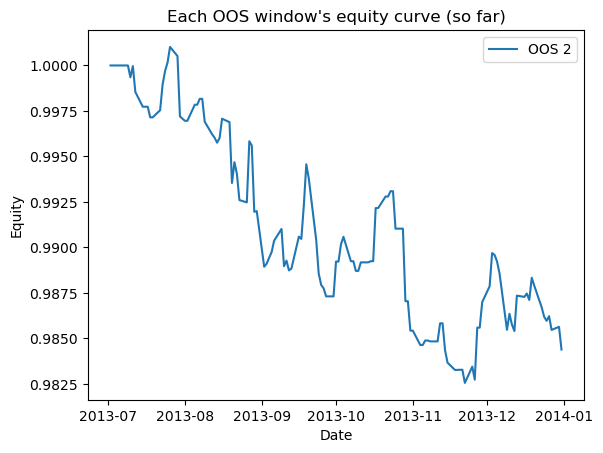


=== Walk-forward window 3 ===
Train: 2013-01-01 ~ 2013-12-31
Test:  2014-01-01 ~ 2014-06-30
  [1/3] Testing threshold=0.0050... Sharpe=-0.214 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-0.090 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-0.718
Best threshold for window 3: 0.0100 (Sharpe=-0.090)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (128, 8)


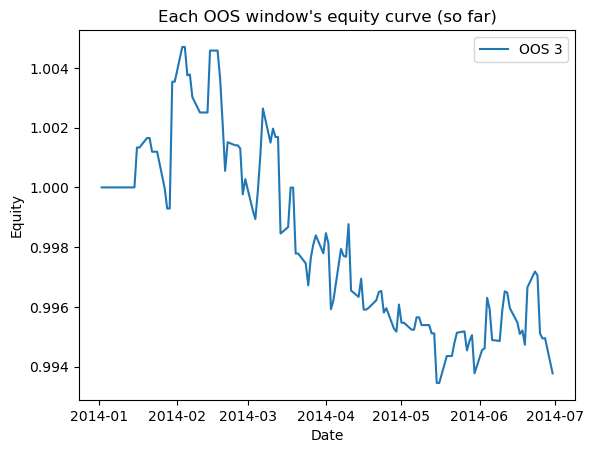


=== Walk-forward window 4 ===
Train: 2013-07-01 ~ 2014-06-30
Test:  2014-07-01 ~ 2014-12-31
  [1/3] Testing threshold=0.0050... Sharpe=-1.082 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-1.728
  [3/3] Testing threshold=0.0150... Sharpe=-0.629 <-- new best
Best threshold for window 4: 0.0150 (Sharpe=-0.629)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (131, 8)


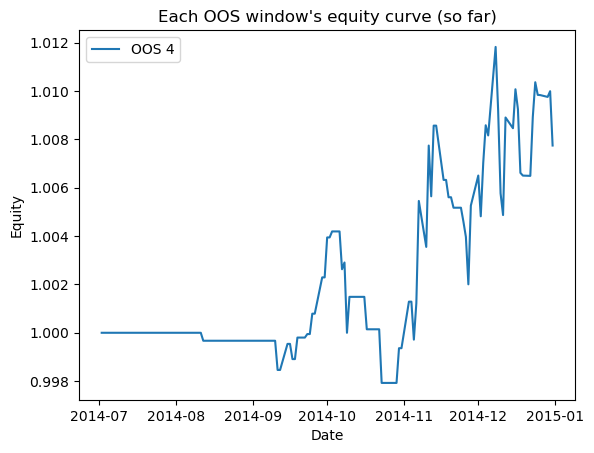


=== Walk-forward window 5 ===
Train: 2014-01-01 ~ 2014-12-31
Test:  2015-01-01 ~ 2015-06-30
  [1/3] Testing threshold=0.0050... Sharpe=0.493 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=1.154 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=1.344 <-- new best
Best threshold for window 5: 0.0150 (Sharpe=1.344)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (128, 8)


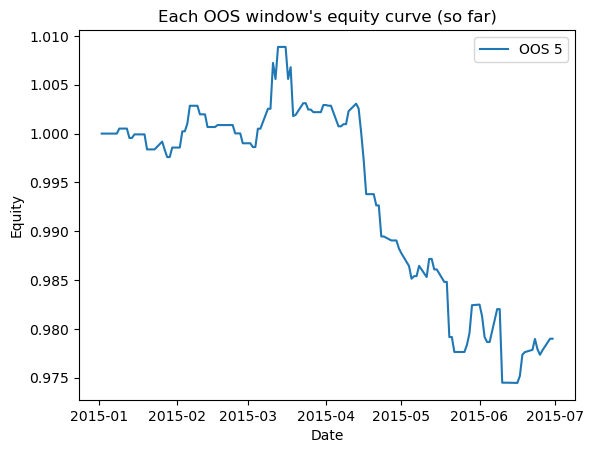


=== Walk-forward window 6 ===
Train: 2014-07-01 ~ 2015-06-30
Test:  2015-07-01 ~ 2015-12-31
  [1/3] Testing threshold=0.0050... Sharpe=1.407 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=0.864
  [3/3] Testing threshold=0.0150... Sharpe=0.107
Best threshold for window 6: 0.0050 (Sharpe=1.407)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (131, 8)


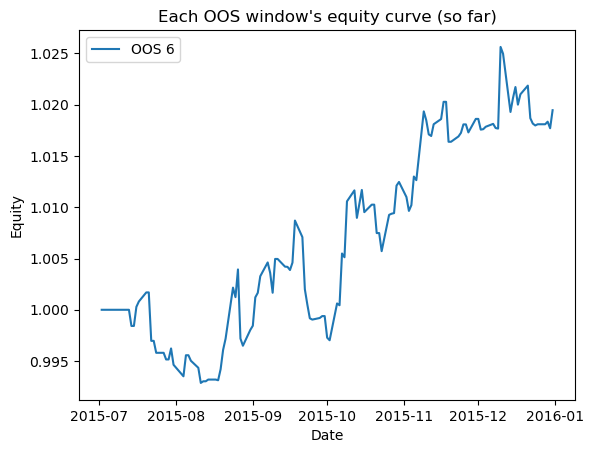


=== Walk-forward window 7 ===
Train: 2015-01-01 ~ 2015-12-31
Test:  2016-01-01 ~ 2016-06-30
  [1/3] Testing threshold=0.0050... Sharpe=0.995 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=1.452 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=0.356
Best threshold for window 7: 0.0100 (Sharpe=1.452)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (129, 8)


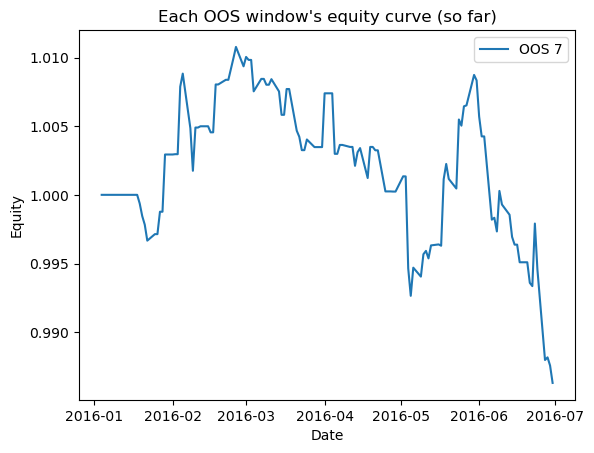


=== Walk-forward window 8 ===
Train: 2015-07-01 ~ 2016-06-30
Test:  2016-07-01 ~ 2016-12-31
  [1/3] Testing threshold=0.0050... Sharpe=0.114 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=1.366 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=0.789
Best threshold for window 8: 0.0100 (Sharpe=1.366)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (130, 8)


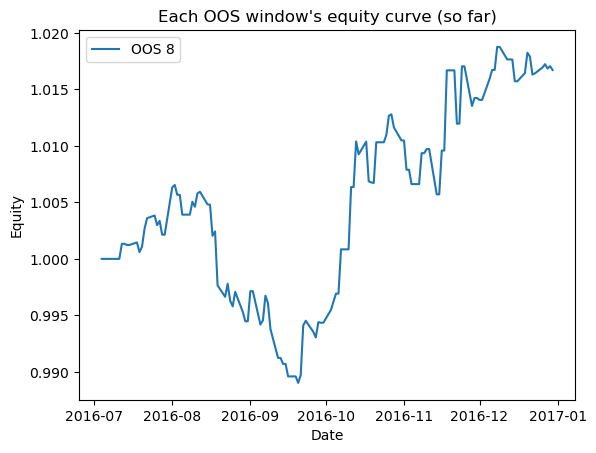


=== Walk-forward window 9 ===
Train: 2016-01-01 ~ 2016-12-31
Test:  2017-01-01 ~ 2017-06-30
  [1/3] Testing threshold=0.0050... Sharpe=0.046 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=0.033
  [3/3] Testing threshold=0.0150... Sharpe=-0.270
Best threshold for window 9: 0.0050 (Sharpe=0.046)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (129, 8)


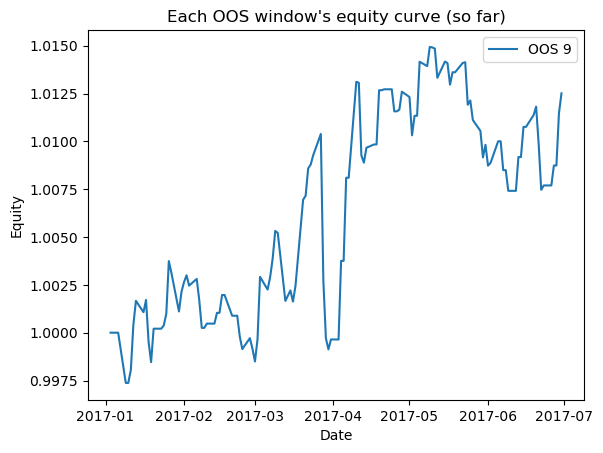


=== Walk-forward window 10 ===
Train: 2016-07-01 ~ 2017-06-30
Test:  2017-07-01 ~ 2017-12-31
  [1/3] Testing threshold=0.0050... Sharpe=1.136 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=0.569
  [3/3] Testing threshold=0.0150... Sharpe=-0.599
Best threshold for window 10: 0.0050 (Sharpe=1.136)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (129, 8)


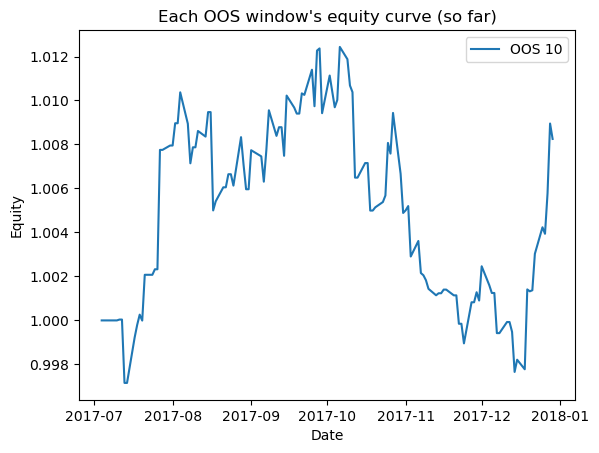


=== Walk-forward window 11 ===
Train: 2017-01-01 ~ 2017-12-31
Test:  2018-01-01 ~ 2018-06-30
  [1/3] Testing threshold=0.0050... Sharpe=0.699 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-0.356
  [3/3] Testing threshold=0.0150... Sharpe=-0.741
Best threshold for window 11: 0.0050 (Sharpe=0.699)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (129, 8)


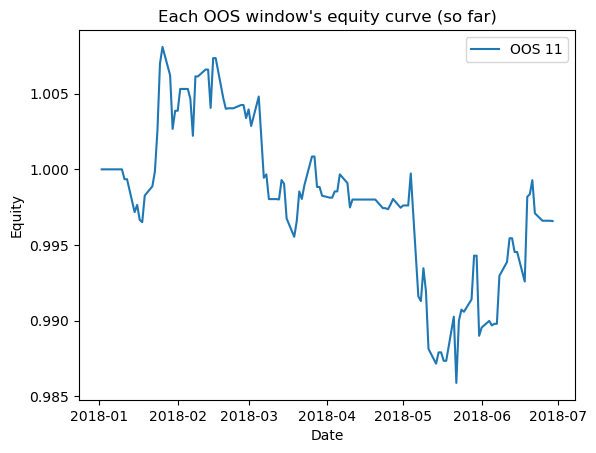


=== Walk-forward window 12 ===
Train: 2017-07-01 ~ 2018-06-30
Test:  2018-07-01 ~ 2018-12-31
  [1/3] Testing threshold=0.0050... Sharpe=0.538 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=0.639 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-0.166
Best threshold for window 12: 0.0100 (Sharpe=0.639)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (130, 8)


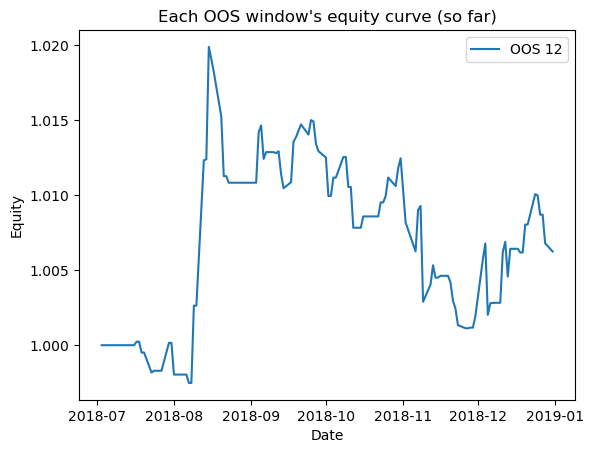


=== Walk-forward window 13 ===
Train: 2018-01-01 ~ 2018-12-31
Test:  2019-01-01 ~ 2019-06-30
  [1/3] Testing threshold=0.0050... Sharpe=-0.045 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=0.123 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-1.450
Best threshold for window 13: 0.0100 (Sharpe=0.123)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (128, 8)


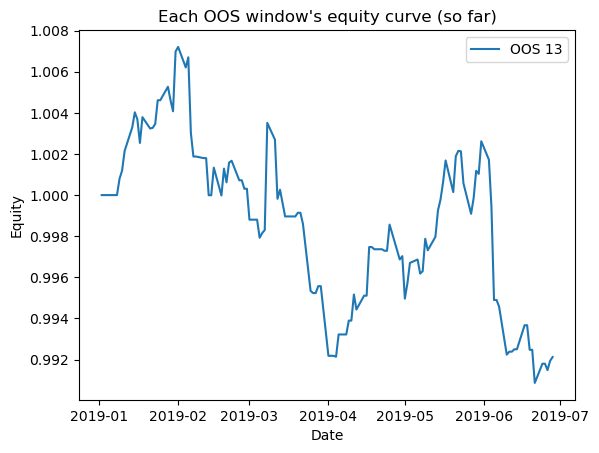


=== Walk-forward window 14 ===
Train: 2018-07-01 ~ 2019-06-30
Test:  2019-07-01 ~ 2019-12-31
  [1/3] Testing threshold=0.0050... Sharpe=-0.970 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-0.551 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-0.580
Best threshold for window 14: 0.0100 (Sharpe=-0.551)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (131, 8)


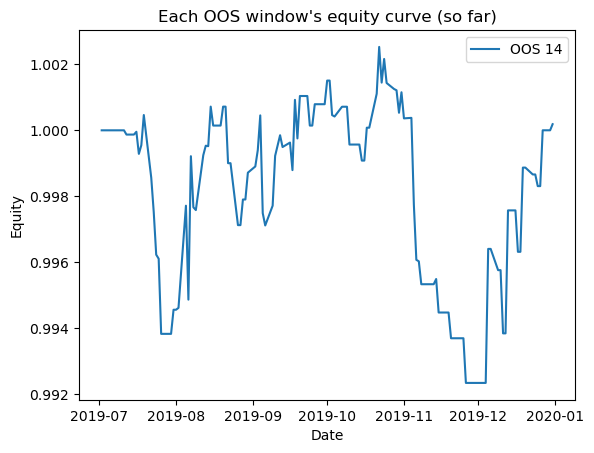


=== Walk-forward window 15 ===
Train: 2019-01-01 ~ 2019-12-31
Test:  2020-01-01 ~ 2020-06-30
  [1/3] Testing threshold=0.0050... Sharpe=-0.847 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=-0.448 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=-0.428 <-- new best
Best threshold for window 15: 0.0150 (Sharpe=-0.428)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (129, 8)


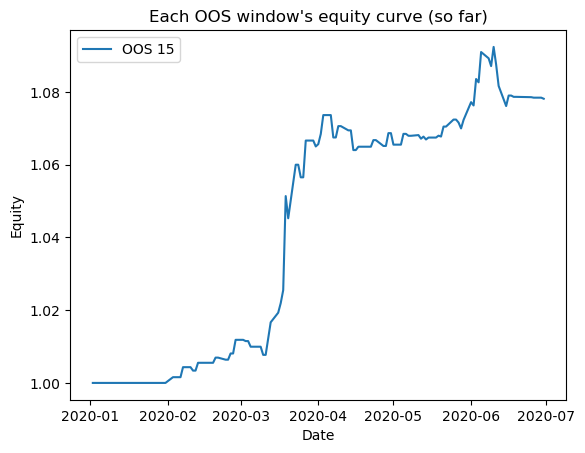


=== Walk-forward window 16 ===
Train: 2019-07-01 ~ 2020-06-30
Test:  2020-07-01 ~ 2020-12-31
  [1/3] Testing threshold=0.0050... Sharpe=1.139 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=1.579 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=1.730 <-- new best
Best threshold for window 16: 0.0150 (Sharpe=1.730)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (131, 8)


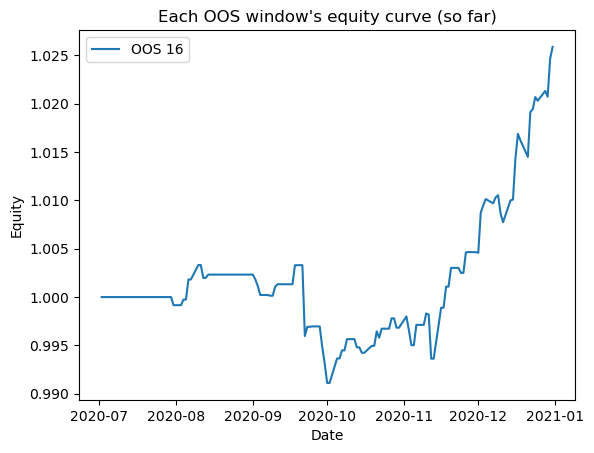


=== Walk-forward window 17 ===
Train: 2020-01-01 ~ 2020-12-31
Test:  2021-01-01 ~ 2021-06-30
  [1/3] Testing threshold=0.0050... Sharpe=1.925 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=2.346 <-- new best
  [3/3] Testing threshold=0.0150... Sharpe=2.592 <-- new best
Best threshold for window 17: 0.0150 (Sharpe=2.592)
  equity_df.columns: ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR', 'mean_equity', 'daily_equity_curve']
  equity_df.shape: (127, 8)


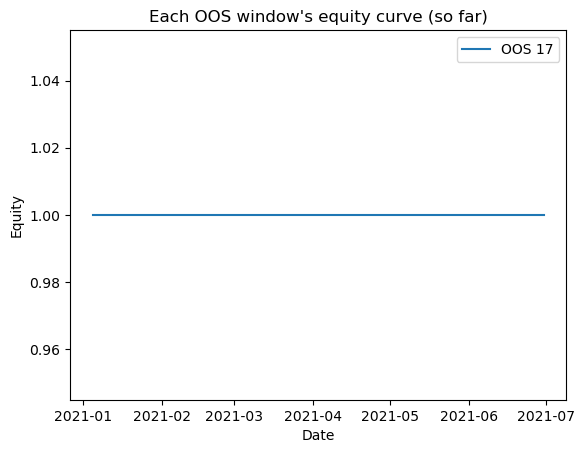


=== Walk-forward window 18 ===
Train: 2020-07-01 ~ 2021-06-30
Test:  2021-07-01 ~ 2021-12-31
  [1/3] Testing threshold=0.0050... Sharpe=1.189 <-- new best
  [2/3] Testing threshold=0.0100... Sharpe=0.720
  [3/3] Testing threshold=0.0150... Sharpe=1.556 <-- new best
Best threshold for window 18: 0.0150 (Sharpe=1.556)

Exception occurred during walk-forward optimization!
Error: Length mismatch: Expected axis has 0 elements, new values have 4 elements
Returning latest available results (partial oos_df and param_path).


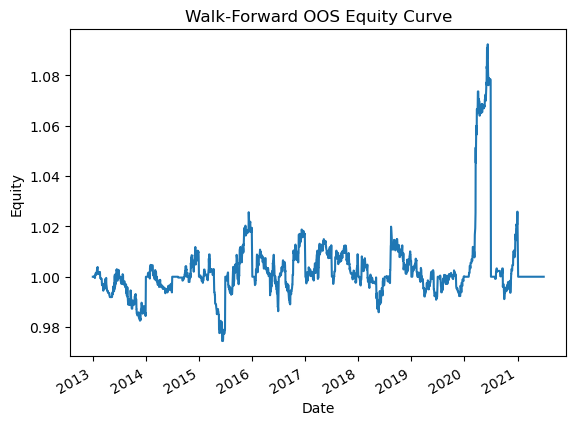

   train_start  train_end test_start   test_end  threshold  sharpe
0   2012-01-01 2012-12-31 2013-01-01 2013-06-30      0.015  -0.121
1   2012-07-01 2013-06-30 2013-07-01 2013-12-31      0.010  -0.531
2   2013-01-01 2013-12-31 2014-01-01 2014-06-30      0.010  -0.090
3   2013-07-01 2014-06-30 2014-07-01 2014-12-31      0.015  -0.629
4   2014-01-01 2014-12-31 2015-01-01 2015-06-30      0.015   1.344
5   2014-07-01 2015-06-30 2015-07-01 2015-12-31      0.005   1.407
6   2015-01-01 2015-12-31 2016-01-01 2016-06-30      0.010   1.452
7   2015-07-01 2016-06-30 2016-07-01 2016-12-31      0.010   1.366
8   2016-01-01 2016-12-31 2017-01-01 2017-06-30      0.005   0.046
9   2016-07-01 2017-06-30 2017-07-01 2017-12-31      0.005   1.136
10  2017-01-01 2017-12-31 2018-01-01 2018-06-30      0.005   0.699
11  2017-07-01 2018-06-30 2018-07-01 2018-12-31      0.010   0.639
12  2018-01-01 2018-12-31 2019-01-01 2019-06-30      0.010   0.123
13  2018-07-01 2019-06-30 2019-07-01 2019-12-31      0.010  -0

C:\Users\Blair Lin\quantTrade_2025\utils\my.py:16: RuntimeWarning: invalid value encountered in scalar divide
  s['Sharpe'] = s['Mean'] / s['Std']


In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# get my myTrade myOption
import sys
sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
import my, myTrade, myOption

def walk_forward_optimize(startDate, endDate, testCcys, threshold_grid, 
                         train_years=3, test_months=6):
    """
    Walk-forward optimize threshold to maximize Sharpe ratio.
    Returns out-of-sample equity curve and parameter path.
    If an error occurs, returns the latest oos_df and param_path collected.
    Also shows each OOS window's equity curve for debugging.
    """
    import matplotlib.pyplot as plt

    startDate = pd.to_datetime(startDate)
    endDate = pd.to_datetime(endDate)
    oos_equity = []
    param_path = []
    dt = startDate

    window_num = 1  # For progress tracking

    try:
        while dt + relativedelta(years=train_years) + relativedelta(months=test_months) <= endDate:
            train_start = dt
            train_end = dt + relativedelta(years=train_years) - timedelta(days=1)
            test_start = train_end + timedelta(days=1)
            test_end = test_start + relativedelta(months=test_months) - timedelta(days=1)
            if test_end > endDate:
                test_end = endDate

            print(f"\n=== Walk-forward window {window_num} ===")
            print(f"Train: {train_start.strftime('%Y-%m-%d')} ~ {train_end.strftime('%Y-%m-%d')}")
            print(f"Test:  {test_start.strftime('%Y-%m-%d')} ~ {test_end.strftime('%Y-%m-%d')}")

            best_sharpe = -np.inf
            best_thresh = None

            # 1. Parameter search
            for i, thresh in enumerate(threshold_grid):
                print(f"  [{i+1}/{len(threshold_grid)}] Testing threshold={thresh:.4f}...", end="")
                equity_df, _ = get_composite_equity_curve(
                    train_start.strftime('%Y-%m-%d'), 
                    train_end.strftime('%Y-%m-%d'), 
                    testCcys, threshold=thresh)
                daily_ret = equity_df['daily_equity_curve']
                stats = my.getDetailedTradingStats(daily_ret, 
                                                   train_start.strftime('%Y-%m-%d'), 
                                                   train_end.strftime('%Y-%m-%d'))
                sharpe = stats.loc['回測期間', 'yearlySharpe']
                print(f" Sharpe={sharpe:.3f}", end="")
                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_thresh = thresh
                    print(" <-- new best", end="")
                print()

            print(f"Best threshold for window {window_num}: {best_thresh:.4f} (Sharpe={best_sharpe:.3f})")

            # 2. Apply best parameter to test window
            equity_df, _ = get_composite_equity_curve(
                test_start.strftime('%Y-%m-%d'), 
                test_end.strftime('%Y-%m-%d'), 
                testCcys, threshold=best_thresh)
            equity_df = equity_df.loc[test_start:test_end]

            # Debug: Print columns and shape
            print(f"  equity_df.columns: {list(equity_df.columns)}")
            print(f"  equity_df.shape: {equity_df.shape}")

            required_cols = ['mean_equity', 'daily_equity_curve']
            if all(col in equity_df.columns for col in required_cols):
                # Plot this window's equity curve
                plt.plot(equity_df.index, equity_df['mean_equity'], label=f"OOS {window_num}")
                oos_equity.append(equity_df[required_cols])
            else:
                print(f"  [WARNING] Missing columns in equity_df: {set(required_cols) - set(equity_df.columns)}. Skipping this window.")

            param_path.append({'train_start': train_start, 
                               'train_end': train_end, 
                               'test_start': test_start, 
                               'test_end': test_end, 
                               'threshold': best_thresh, 
                               'sharpe': best_sharpe})

            dt = dt + relativedelta(months=test_months)
            window_num += 1
            oos_df = pd.concat(oos_equity) if oos_equity else pd.DataFrame()
            oos_df = oos_df[~oos_df.index.duplicated(keep='first')]
            plt.legend()
            plt.title("Each OOS window's equity curve (so far)")
            plt.xlabel("Date")
            plt.ylabel("Equity")
            plt.show()
    except Exception as e:
        print("\nException occurred during walk-forward optimization!")
        print(f"Error: {e}")
        print("Returning latest available results (partial oos_df and param_path).")


        return oos_df, pd.DataFrame(param_path), e

    # Concatenate out-of-sample periods
    oos_df = pd.concat(oos_equity) if oos_equity else pd.DataFrame()
    oos_df = oos_df[~oos_df.index.duplicated(keep='first')]

    plt.legend()
    plt.title("Each OOS window's equity curve")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.show()

    print(f"\nWalk-forward complete! Total windows: {window_num-1}")
    return oos_df, pd.DataFrame(param_path), None  # None means no error

# --- Example usage ---
# startDate = '2017-01-01'
# endDate = '2021-12-31'

startDate = '2012-01-01'
endDate = '2025-04-30'

# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'SEK', 'ZAR', 'CHF'] # sr around 0.68, avg return 0.57%
ccy_dict = {
    'ccyPairs1': ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'SEK', 'ZAR', 'CHF'],
    'ccyPairs2': ['EUR', 'GBP', 'AUD', 'NZD', 'SEK', 'ZAR']
}

# get the string of the variable name

testCcys_name = 'ccyPairs2'
testCcys = ccy_dict[testCcys_name]
threshold_grid = np.arange(0.005, 0.02, 0.005)

oos_df, param_path, error = walk_forward_optimize(
    startDate, endDate, testCcys, threshold_grid,
    train_years=1, test_months=6)

if not oos_df.empty:
    oos_df['mean_equity'].plot(title='Walk-Forward OOS Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.show()

    my.getDetailedTradingStats(oos_df['daily_equity_curve'], oos_df.index[0], oos_df.index[-1])

    print(param_path)
else:
    print("No equity curve data was generated.")

if error:
    print("Warning: The walk-forward optimization did not complete successfully.")

In [15]:
# store the results to csv
param_path.to_csv(f'walk_forward_param_path_{testCcys_name}.csv', index=False)
oos_df.to_csv(f'walk_forward_oos_equity_{testCcys_name}.csv')

<Axes: title={'center': 'Walk-Forward OOS Cumulative Return'}>

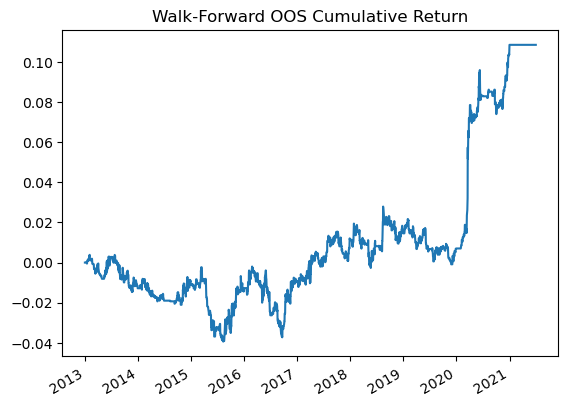

In [16]:
oos_df['daily_equity_curve'].cumsum().plot(title='Walk-Forward OOS Cumulative Return')

In [17]:
my.getDetailedTradingStats(oos_df['daily_equity_curve'], oos_df.index[0], '2020-12-31')

,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe,yearlyProfit(pos=USD1mio),dailyStd(pos=USD1mio)
2013,-1.28,0.12,1.86,-0.671,"-12,800","1,200"
2014,0.16,0.11,1.30,0.092,"1,600","1,100"
2015,-0.15,0.18,3.71,-0.053,"-1,500","1,800"
2016,0.32,0.18,3.53,0.109,"3,200","1,800"
2017,2.09,0.15,1.47,0.886,"20,900","1,500"
2018,0.32,0.18,2.22,0.112,"3,200","1,800"
2019,-0.75,0.12,2.26,-0.398,"-7,500","1,200"
2020,10.16,0.26,2.20,2.423,"101,600","2,600"
回測期間,1.32,0.17,4.33,0.500,"13,200","1,700"


In [13]:
param_path

,train_start,train_end,test_start,test_end,threshold,sharpe
0,2012-01-01,2012-12-31,2013-01-01,2013-06-30,0.015,-0.121
1,2012-07-01,2013-06-30,2013-07-01,2013-12-31,0.010,-0.531
2,2013-01-01,2013-12-31,2014-01-01,2014-06-30,0.010,-0.090
3,2013-07-01,2014-06-30,2014-07-01,2014-12-31,0.015,-0.629
4,2014-01-01,2014-12-31,2015-01-01,2015-06-30,0.015,1.344
5,2014-07-01,2015-06-30,2015-07-01,2015-12-31,0.005,1.407
6,2015-01-01,2015-12-31,2016-01-01,2016-06-30,0.010,1.452
7,2015-07-01,2016-06-30,2016-07-01,2016-12-31,0.010,1.366
8,2016-01-01,2016-12-31,2017-01-01,2017-06-30,0.005,0.046
9,2016-07-01,2017-06-30,2017-07-01,2017-12-31,0.005,1.136


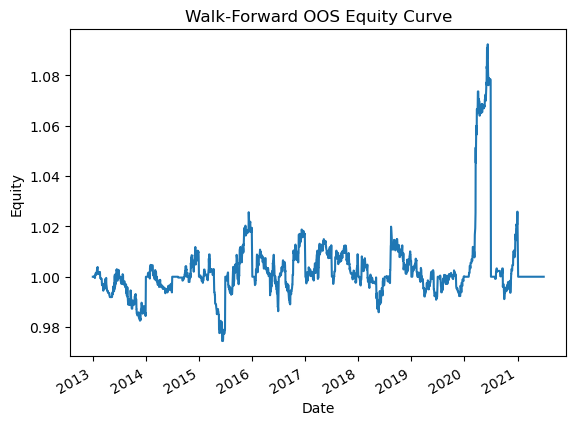

In [14]:
# Plot the final walk-forward out-of-sample curve
oos_df['mean_equity'].plot(title='Walk-Forward OOS Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.show()
